In [6]:
pip install pytorch-msssim

In [7]:
import os
import time
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
from pytorch_msssim import ssim

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Training classifier params
CLS_EPOCHS = 50
CLS_BATCH = 128
CLS_LR = 0.1

# Generator / inversion params
GEN_EPOCHS = 100
GEN_BATCH = 64
latent_dim = 100
cond_dim = 10
F_ch = 64                 # channels at 10x10 stage
alpha, beta, gamma, delta = 100.0, 100.0, 1000.0, 1000.0

# Other
NUM_CLASSES = 10
SAMPLES_PER_CLASS = 20    # for evaluation
SAVE_MODEL_PATH = "resnet_mnist.pth"
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

Device: cuda


In [9]:
transform = transforms.Compose([
    transforms.Resize(32),     # Resize MNIST to 32x32 so generator architecture can remain same
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                      download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                     download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False)

In [13]:
class ResNetFMNIST(nn.Module):
    def __init__(self, num_classes=10, pretrained=True):
        super().__init__()

        self.resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)

        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.resnet.maxpool = nn.Identity()  # remove downsampling

        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, num_classes)

    def forward(self, x, return_features=False):
        # Replicate torchvision forward manually to access penultimate features
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)
        x = self.resnet.avgpool(x)
        feat = torch.flatten(x, 1)
        logits = self.resnet.fc(feat)

        if return_features:
            return logits, feat
        return logits


# Instantiate
classifier = ResNetFMNIST(num_classes=NUM_CLASSES).to(device)

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer_cls = optim.SGD(classifier.parameters(), lr=CLS_LR, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer_cls, milestones=[60, 120, 160], gamma=0.2)

def train_classifier_one_epoch(epoch):
    classifier.train()
    running_loss, correct, total = 0.0, 0, 0
    start = time.time()
    for inputs, targets in trainloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer_cls.zero_grad()
        outputs = classifier(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer_cls.step()
        running_loss += loss.item() * targets.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    train_loss = running_loss / total
    train_acc = 100. * correct / total
    print(f"[CLS] Epoch {epoch} Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}% Time: {time.time()-start:.1f}s")
    return train_loss, train_acc

def test_classifier(epoch):
    classifier.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = classifier(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * targets.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    test_loss = running_loss / total
    acc = 100. * correct / total
    print(f"[CLS] Epoch {epoch} Test Loss: {test_loss:.4f} Acc: {acc:.2f}%")
    return test_loss, acc

Training classifier from scratch...
[CLS] Epoch 1 Train Loss: 1.3561 Acc: 66.90% Time: 58.2s
[CLS] Epoch 1 Test Loss: 0.5610 Acc: 78.81%
[CLS] Saved best model (acc=78.81%)
[CLS] Epoch 2 Train Loss: 0.4480 Acc: 83.23% Time: 60.4s
[CLS] Epoch 2 Test Loss: 0.4283 Acc: 84.27%
[CLS] Saved best model (acc=84.27%)
[CLS] Epoch 3 Train Loss: 0.3653 Acc: 86.53% Time: 58.9s
[CLS] Epoch 3 Test Loss: 0.3704 Acc: 86.48%
[CLS] Saved best model (acc=86.48%)
[CLS] Epoch 4 Train Loss: 0.3258 Acc: 87.94% Time: 58.7s
[CLS] Epoch 4 Test Loss: 0.3790 Acc: 86.29%
[CLS] Epoch 5 Train Loss: 0.2991 Acc: 88.86% Time: 59.0s
[CLS] Epoch 5 Test Loss: 0.3238 Acc: 88.07%
[CLS] Saved best model (acc=88.07%)
[CLS] Epoch 6 Train Loss: 0.2814 Acc: 89.54% Time: 58.9s
[CLS] Epoch 6 Test Loss: 0.3745 Acc: 86.12%
[CLS] Epoch 7 Train Loss: 0.2682 Acc: 89.96% Time: 58.9s
[CLS] Epoch 7 Test Loss: 0.3725 Acc: 85.95%
[CLS] Epoch 8 Train Loss: 0.2552 Acc: 90.53% Time: 58.8s
[CLS] Epoch 8 Test Loss: 0.3254 Acc: 87.94%
[CLS] Epoch 

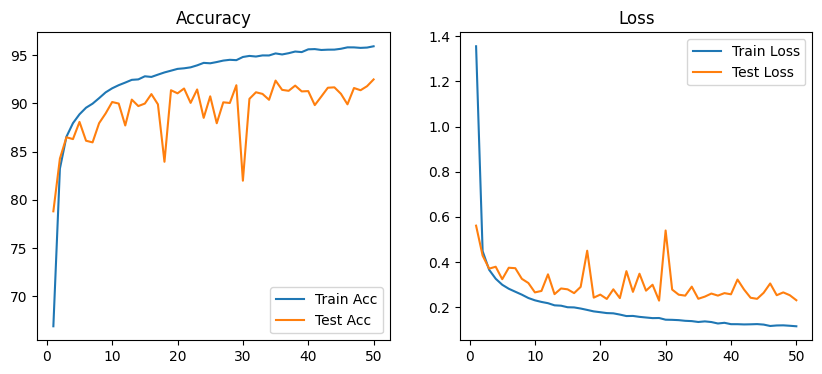

ResNetFMNIST(
  (resnet): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): Identity()
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        

In [15]:
def train_classifier(epochs=CLS_EPOCHS):
    best_acc = 0.0
    train_losses, train_accs = [], []
    test_losses, test_accs = [], []
    for ep in range(1, epochs+1):
        tr_loss, tr_acc = train_classifier_one_epoch(ep)
        te_loss, te_acc = test_classifier(ep)
        scheduler.step()
        train_losses.append(tr_loss); train_accs.append(tr_acc)
        test_losses.append(te_loss); test_accs.append(te_acc)
        if te_acc > best_acc:
            best_acc = te_acc
            torch.save(classifier.state_dict(), SAVE_MODEL_PATH)
            print(f"[CLS] Saved best model (acc={best_acc:.2f}%)")
    # plot training curves
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(range(1,len(train_accs)+1), train_accs, label='Train Acc')
    plt.plot(range(1,len(test_accs)+1), test_accs, label='Test Acc')
    plt.title("Accuracy")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(range(1,len(train_losses)+1), train_losses, label='Train Loss')
    plt.plot(range(1,len(test_losses)+1), test_losses, label='Test Loss')
    plt.title("Loss")
    plt.legend()
    plt.show()

# Only train classifier if model file not present
if not os.path.isfile(SAVE_MODEL_PATH):
    print("Training classifier from scratch...")
    train_classifier(epochs=CLS_EPOCHS)
else:
    print("Found saved classifier. Loading...")
    classifier.load_state_dict(torch.load(SAVE_MODEL_PATH, map_location=device))

# Freeze classifier (but allow autograd to flow into generator through the classifier's ops)
for p in classifier.parameters():
    p.requires_grad = False
classifier.eval()

In [16]:
# We will pass the **softmaxed** conditioning vector INTO the generator (so it's a distribution).
def sample_vector_condition(batch, num_classes, device):
    v = torch.randn(batch, num_classes, device=device)
    P = F.softmax(v, dim=1)      # conditioning distribution P (batch, num_classes)
    labels = P.argmax(dim=1)     # integer labels used in CE target
    return P, P, labels         # return vector_cond (P), P_target, labels

# Precompute 'hot' matrices for all classes and reuse
_precomputed_hot = torch.zeros(NUM_CLASSES, 1, NUM_CLASSES, NUM_CLASSES, device=device)
for k in range(NUM_CLASSES):
    mat = torch.zeros(NUM_CLASSES, NUM_CLASSES, device=device)
    mat[k, :] = 1.0
    mat[:, k] = 1.0
    _precomputed_hot[k, 0] = mat

def build_hot_matrix(labels, N=NUM_CLASSES, device=device):
    # labels: (batch,) ints on device
    # returns (batch,1,10,10) by creating appropriate matrices
    batch_size = labels.size(0)
    hot_mats = torch.zeros(batch_size, 1, 10, 10, device=device)

    for i, label in enumerate(labels):
        # Create a 10x10 matrix with the label information
        # You can experiment with different patterns here
        mat = torch.zeros(10, 10, device=device)

        # Simple pattern: set rows and columns corresponding to label
        mat[label, :] = 1.0
        mat[:, label] = 1.0

        hot_mats[i, 0] = mat

    return hot_mats

In [17]:
# Fix the generator architecture first
class Generator(nn.Module):
    def __init__(self, latent_dim=latent_dim, cond_dim=cond_dim, F=F_ch, out_ch=1):
        super().__init__()
        self.latent_dim = latent_dim
        self.cond_dim = cond_dim

        # Initial projection to 4x4
        self.convT1 = nn.ConvTranspose2d(latent_dim + cond_dim, F * 8, kernel_size=4, stride=1, padding=0)  # 1x1 -> 4x4
        self.bn1 = nn.BatchNorm2d(F * 8)

        # 4x4 -> 8x8
        self.convT2 = nn.ConvTranspose2d(F * 8 + 1, F * 4, kernel_size=4, stride=2, padding=1)  # +1 for hot channel
        self.bn2 = nn.BatchNorm2d(F * 4)

        # 8x8 -> 16x16
        self.convT3 = nn.ConvTranspose2d(F * 4, F * 2, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(F * 2)

        # 16x16 -> 32x32
        self.convT4 = nn.ConvTranspose2d(F * 2, F, kernel_size=4, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(F)

        # Final convolution to get 1 channels
        self.final_conv = nn.Conv2d(F, out_ch, kernel_size=3, stride=1, padding=1)
        self.dropout = nn.Dropout2d(0.2)  # Reduced dropout

    def forward(self, z, vec_cond, hot_mat):
        # z: (B, latent), vec_cond: (B, cond_dim), hot_mat: (B,1,10,10)
        x = torch.cat([z, vec_cond], dim=1)           # (B, latent+cond)
        x = x.view(x.size(0), x.size(1), 1, 1)        # (B, latent+cond,1,1)

        # 1x1 -> 4x4
        x = F.leaky_relu(self.bn1(self.convT1(x)), 0.2)

        # Resize hot_mat to match current feature size (4x4)
        hot_resized = F.interpolate(hot_mat, size=(4, 4), mode='bilinear', align_corners=False)
        x = torch.cat([x, hot_resized], dim=1)

        # 4x4 -> 8x8
        x = F.leaky_relu(self.bn2(self.convT2(x)), 0.2)
        x = self.dropout(x)

        # 8x8 -> 16x16
        x = F.leaky_relu(self.bn3(self.convT3(x)), 0.2)

        # 16x16 -> 32x32
        x = F.leaky_relu(self.bn4(self.convT4(x)), 0.2)

        img = torch.tanh(self.final_conv(x))  # range [-1,1]
        return img

In [18]:
def kl_divergence_targetP(logits, P_target):
    # D_KL(P_target || Q_pred)
    # logits: (B,C); P_target: (B,C)
    log_softmax = F.log_softmax(logits, dim=1)
    kl_div = F.kl_div(log_softmax, P_target, reduction='batchmean', log_target=False)
    return kl_div

def cosine_similarity_loss(features):
    # features: (B, D)
    eps = 1e-8
    f = features / (features.norm(dim=1, keepdim=True) + eps)  # normalize
    sim = f @ f.T  # (B,B)
    B = features.size(0)
    off_diag_sum = sim.sum() - B  # subtract diagonal ones
    denom = B * (B - 1)
    return off_diag_sum / (denom + 1e-12)

def orthogonality_loss(features):
    # make normalized features orthogonal (Gram approx I)
    eps = 1e-8
    f = features / (features.norm(dim=1, keepdim=True) + eps)
    G = f @ f.T
    B = features.size(0)
    I = torch.eye(B, device=features.device)
    return ((G - I)**2).mean()
def ssim_loss(imgs, ref_imgs):
    """
    Structural Similarity (SSIM) loss between generated and reference images.
    Both tensors in range [-1, 1].
    Returns (1 - SSIM) averaged over the batch.
    """
    return 1 - ssim(imgs, ref_imgs, data_range=2.0, size_average=True)
# Improved loss function with better balancing
def compute_inversion_loss(
    logits, features, P_target, labels,
    imgs=None, ref_imgs=None,
    alpha=1.0, beta=1.0, gamma=0.01, delta=0.01, eta=0.5
):
    """
    Total inversion loss = α * KL + β * CE + γ * CosSim + δ * Orthogonality + η * (1 - SSIM)
    """

    # Core inversion losses
    L_kl = kl_divergence_targetP(logits, P_target)
    L_ce = F.cross_entropy(logits, labels)
    L_cos = cosine_similarity_loss(features)
    L_ortho = orthogonality_loss(features)

    # SSIM Loss (optional, requires reference images)
    if imgs is not None and ref_imgs is not None:
        L_ssim = ssim_loss(imgs, ref_imgs)
    else:
        L_ssim = torch.tensor(0.0, device=logits.device)

    total_loss = (
        alpha * L_kl +
        beta * L_ce +
        gamma * L_cos +
        delta * L_ortho +
        eta * L_ssim
    )

    return {
        "L_kl": L_kl,
        "L_ce": L_ce,
        "L_cos": L_cos,
        "L_ortho": L_ortho,
        "L_ssim": L_ssim,
        "total": total_loss
    }



In [19]:
alpha, beta, gamma, delta, eta = 100.0, 200.0, 1000.0, 1000.0, 1000.0  # tuned weights
gen = Generator(out_ch=1).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=1e-4, betas=(0.5, 0.999))

def train_generator(epochs=GEN_EPOCHS, batch_size=GEN_BATCH):
    gen.train()

    for ep in range(1, epochs + 1):
        epoch_loss = epoch_Lkl = epoch_Lce = epoch_Lcos = epoch_Lortho = epoch_Lssim = 0.0
        t0 = time.time()
        steps = len(trainloader)

        for step in range(steps):
            # Sample conditioning
            vec_cond, P_target, labels = sample_vector_condition(batch_size, NUM_CLASSES, device)
            z = torch.randn(batch_size, latent_dim, device=device)
            hot = build_hot_matrix(labels, N=NUM_CLASSES, device=device)

            # Generate images
            imgs = gen(z, vec_cond, hot)

            # Create structural reference (slightly perturbed copy)
            ref_imgs = imgs + 0.02 * torch.randn_like(imgs)

            # Forward through frozen classifier
            logits, features = classifier(imgs, return_features=True)

            # Compute combined inversion + SSIM loss
            loss_dict = compute_inversion_loss(
                logits, features, P_target, labels,
                imgs=imgs, ref_imgs=ref_imgs,
                alpha=alpha, beta=beta, gamma=gamma, delta=delta, eta=eta
            )

            total_loss = loss_dict["total"] # Rename the variable to avoid conflict

            gen_opt.zero_grad()
            total_loss.backward() # Use the renamed variable
            torch.nn.utils.clip_grad_norm_(gen.parameters(), max_norm=1.0)
            gen_opt.step()

            # Accumulate stats
            epoch_loss += total_loss.item()
            epoch_Lkl += loss_dict["L_kl"].item()
            epoch_Lce += loss_dict["L_ce"].item()
            epoch_Lcos += loss_dict["L_cos"].item()
            epoch_Lortho += loss_dict["L_ortho"].item()
            epoch_Lssim += loss_dict["L_ssim"].item()


        # Epoch summary
        steps = float(steps)
        print(f"[GEN] Ep {ep}/{epochs} | Loss {epoch_loss/steps:.4f} | "
              f"KL {epoch_Lkl/steps:.4f} | CE {epoch_Lce/steps:.4f} | "
              f"COS {epoch_Lcos/steps:.4f} | ORT {epoch_Lortho/steps:.4f} | "
              f"SSIM {epoch_Lssim/steps:.4f} | time {time.time()-t0:.1f}s")

        # Evaluate & visualize every few epochs
        if ep % 10 == 0:
            acc = inversion_accuracy(gen, classifier)
            print(f"[GEN] Inversion Accuracy: {acc:.2f}%")
            show_generated_images(gen, classifier, samples_per_class=4)
            torch.save(gen.state_dict(), f"gen_epoch{ep}.pth")

In [20]:
def inversion_accuracy(
    gen,
    classifier,
    num_classes=NUM_CLASSES,
    n_per_class=100,
    latent_dim=latent_dim,
    batch_size=32
):
    """
    Inversion Accuracy refers to the percentage of images generated with desired labels same as the output labels from the classifier.
    """
    gen.eval()
    classifier.eval()

    correct, total = 0, 0

    with torch.no_grad():
        for cls in range(num_classes):
            for start in range(0, n_per_class, batch_size):
                bsz = min(batch_size, n_per_class - start)
                z = torch.randn(bsz, latent_dim, device=device)
                c = torch.zeros(bsz, num_classes, device=device)
                c[:, cls] = 1.0
                hot = build_hot_matrix(torch.full((bsz,), cls, device=device), N=num_classes, device=device)

                imgs = gen(z, c, hot)
                logits, _ = classifier(imgs, return_features=True)
                preds = logits.argmax(dim=1)

                correct += (preds == cls).sum().item()
                total += bsz

    return 100.0 * correct / total


def show_generated_images(
    gen,
    classifier,
    latent_dim=latent_dim,
    num_classes=NUM_CLASSES,
    samples_per_class=8
):
    gen.eval()
    classifier.eval()

    with torch.no_grad():
        fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(samples_per_class, num_classes))

        for cls in range(num_classes):
            # 1. Sample Latent + Conditioning
            z = torch.randn(samples_per_class, latent_dim, device=device)
            c = torch.zeros(samples_per_class, num_classes, device=device)
            c[:, cls] = 1.0  # one-hot class conditioning
            hot = build_hot_matrix(torch.full((samples_per_class,), cls, device=device),
                                   N=num_classes, device=device)

            # 2. Generate Images
            imgs = gen(z, c, hot)

            # 3. Classifier Prediction (batch-based → efficient)
            logits, _ = classifier(imgs, return_features=True)
            preds = logits.argmax(dim=1)

            # 4. Convert to displayable format
            imgs = (imgs + 1.0) / 2.0
            imgs = imgs.clamp(0, 1)

            for i in range(samples_per_class):
                ax = axes[cls, i] if num_classes > 1 else axes[i]
                img = imgs[i].cpu().squeeze().numpy()
                plt.imshow(img, cmap='gray')


                ax.imshow(img)
                ax.axis("off")

                true_label = cls
                pred_label = preds[i].item()
                color = "green" if true_label == pred_label else "red"

                ax.set_title(f"T:{true_label} | P:{pred_label}", fontsize=8, color=color)

        plt.tight_layout()
        plt.show()


def eval_tsne_grid(
    gen,
    classifier,
    samples_per_class=100,
    num_classes=NUM_CLASSES,
    latent_dim=latent_dim,
    seed=42
):
    gen.eval()
    classifier.eval()
    all_features, all_labels, all_preds = [], [], []

    torch.manual_seed(seed)
    np.random.seed(seed)

    with torch.no_grad():
        for label in range(num_classes):
            labels = torch.full((samples_per_class,), label, dtype=torch.long, device=device)
            v_raw = F.softmax(torch.randn(samples_per_class, num_classes, device=device), dim=1)
            hot_mat = build_hot_matrix(labels, N=num_classes, device=device)
            z = torch.randn(samples_per_class, latent_dim, device=device)

            imgs = gen(z, v_raw, hot_mat)
            logits, feats = classifier(imgs, return_features=True)
            preds = logits.argmax(dim=1)

            all_features.append(feats.cpu())
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())

    # Concatenate
    all_features = torch.cat(all_features, dim=0).numpy()
    all_labels = torch.cat(all_labels, dim=0).numpy()
    all_preds = torch.cat(all_preds, dim=0).numpy()

    acc = np.mean(all_labels == all_preds) * 100
    print(f"[t-SNE] Inversion Accuracy: {acc:.2f}%")

    # Dimensionality reduction
    pca = PCA(n_components=min(50, all_features.shape[1]))
    features_pca = pca.fit_transform(all_features)

    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=seed)
    features_2d = tsne.fit_transform(features_pca)
    plt.figure(figsize=(8, 6))
    for label in range(num_classes):
        idx = all_labels == label
        plt.scatter(features_2d[idx, 0], features_2d[idx, 1], label=f"Class {label}", alpha=0.7, s=12)
    plt.legend()
    plt.title("t-SNE of Generator Feature Embeddings")
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.show()

Starting generator training...
[GEN] Ep 1/100 | Loss 1554.9540 | KL 1.0191 | CE 2.3981 | COS 0.5913 | ORT 0.3799 | SSIM 0.0022 | time 28.4s
[GEN] Ep 2/100 | Loss 922.6786 | KL 1.4181 | CE 0.5307 | COS 0.4381 | ORT 0.2342 | SSIM 0.0024 | time 27.8s
[GEN] Ep 3/100 | Loss 791.8522 | KL 1.6373 | CE 0.2574 | COS 0.3823 | ORT 0.1918 | SSIM 0.0025 | time 27.7s
[GEN] Ep 4/100 | Loss 729.7928 | KL 1.6144 | CE 0.1855 | COS 0.3556 | ORT 0.1734 | SSIM 0.0023 | time 27.6s
[GEN] Ep 5/100 | Loss 683.7407 | KL 1.5638 | CE 0.1527 | COS 0.3342 | ORT 0.1605 | SSIM 0.0021 | time 27.8s
[GEN] Ep 6/100 | Loss 650.5792 | KL 1.5173 | CE 0.1378 | COS 0.3175 | ORT 0.1518 | SSIM 0.0021 | time 27.7s
[GEN] Ep 7/100 | Loss 626.9246 | KL 1.4818 | CE 0.1358 | COS 0.3044 | ORT 0.1452 | SSIM 0.0020 | time 27.7s
[GEN] Ep 8/100 | Loss 608.4533 | KL 1.4566 | CE 0.1424 | COS 0.2929 | ORT 0.1395 | SSIM 0.0020 | time 27.7s
[GEN] Ep 9/100 | Loss 593.0381 | KL 1.4411 | CE 0.1419 | COS 0.2835 | ORT 0.1351 | SSIM 0.0019 | time 27

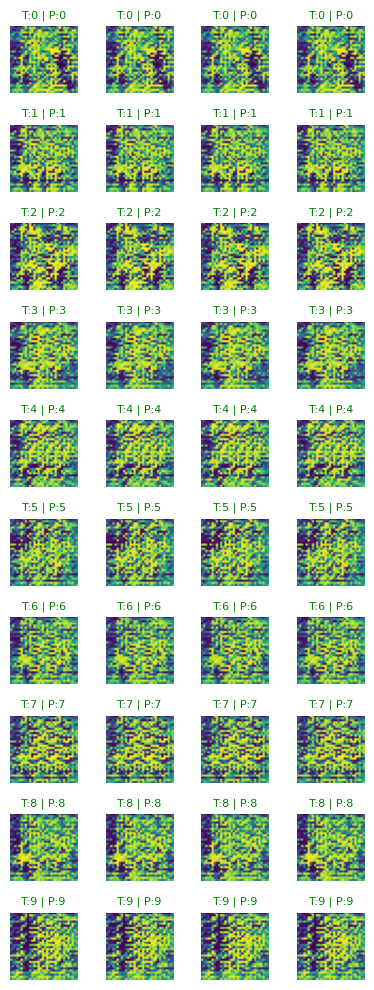

[GEN] Ep 11/100 | Loss 568.4799 | KL 1.3956 | CE 0.1455 | COS 0.2688 | ORT 0.1292 | SSIM 0.0018 | time 27.6s
[GEN] Ep 12/100 | Loss 561.5810 | KL 1.3743 | CE 0.1486 | COS 0.2649 | ORT 0.1278 | SSIM 0.0017 | time 27.6s
[GEN] Ep 13/100 | Loss 557.5284 | KL 1.3628 | CE 0.1526 | COS 0.2622 | ORT 0.1268 | SSIM 0.0017 | time 27.6s
[GEN] Ep 14/100 | Loss 553.1828 | KL 1.3559 | CE 0.1534 | COS 0.2595 | ORT 0.1258 | SSIM 0.0016 | time 27.5s
[GEN] Ep 15/100 | Loss 548.1911 | KL 1.3434 | CE 0.1539 | COS 0.2569 | ORT 0.1246 | SSIM 0.0016 | time 27.6s
[GEN] Ep 16/100 | Loss 545.1118 | KL 1.3351 | CE 0.1554 | COS 0.2549 | ORT 0.1240 | SSIM 0.0016 | time 27.6s
[GEN] Ep 17/100 | Loss 541.4957 | KL 1.3265 | CE 0.1567 | COS 0.2530 | ORT 0.1230 | SSIM 0.0015 | time 27.5s
[GEN] Ep 18/100 | Loss 540.5789 | KL 1.3191 | CE 0.1575 | COS 0.2525 | ORT 0.1231 | SSIM 0.0015 | time 27.5s
[GEN] Ep 19/100 | Loss 537.8527 | KL 1.3126 | CE 0.1595 | COS 0.2507 | ORT 0.1225 | SSIM 0.0015 | time 27.5s
[GEN] Ep 20/100 | L

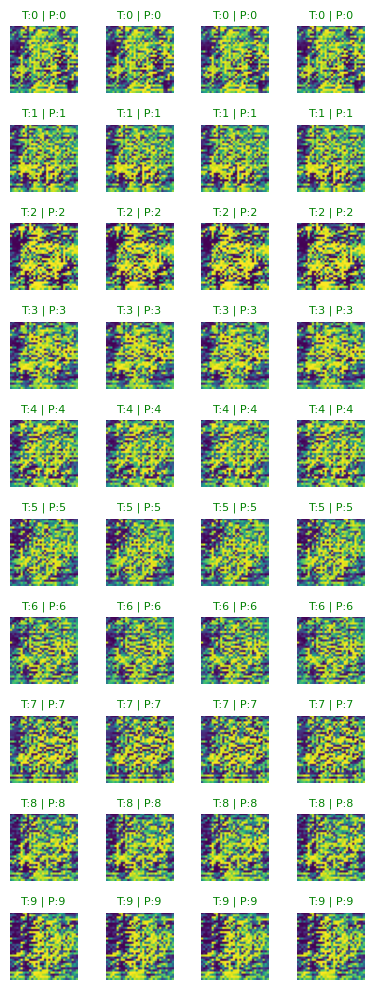

[GEN] Ep 21/100 | Loss 533.5522 | KL 1.3020 | CE 0.1612 | COS 0.2482 | ORT 0.1214 | SSIM 0.0015 | time 27.5s
[GEN] Ep 22/100 | Loss 533.4636 | KL 1.2979 | CE 0.1628 | COS 0.2483 | ORT 0.1214 | SSIM 0.0014 | time 27.7s
[GEN] Ep 23/100 | Loss 529.8211 | KL 1.2949 | CE 0.1615 | COS 0.2464 | ORT 0.1202 | SSIM 0.0014 | time 27.5s
[GEN] Ep 24/100 | Loss 528.3117 | KL 1.2897 | CE 0.1626 | COS 0.2456 | ORT 0.1198 | SSIM 0.0014 | time 27.5s
[GEN] Ep 25/100 | Loss 526.6337 | KL 1.2846 | CE 0.1615 | COS 0.2448 | ORT 0.1197 | SSIM 0.0014 | time 27.6s
[GEN] Ep 26/100 | Loss 526.8995 | KL 1.2822 | CE 0.1622 | COS 0.2450 | ORT 0.1199 | SSIM 0.0014 | time 27.5s
[GEN] Ep 27/100 | Loss 525.1514 | KL 1.2805 | CE 0.1623 | COS 0.2439 | ORT 0.1194 | SSIM 0.0014 | time 27.5s
[GEN] Ep 28/100 | Loss 525.3882 | KL 1.2780 | CE 0.1637 | COS 0.2440 | ORT 0.1195 | SSIM 0.0014 | time 27.7s
[GEN] Ep 29/100 | Loss 524.7804 | KL 1.2745 | CE 0.1641 | COS 0.2437 | ORT 0.1194 | SSIM 0.0014 | time 27.5s
[GEN] Ep 30/100 | L

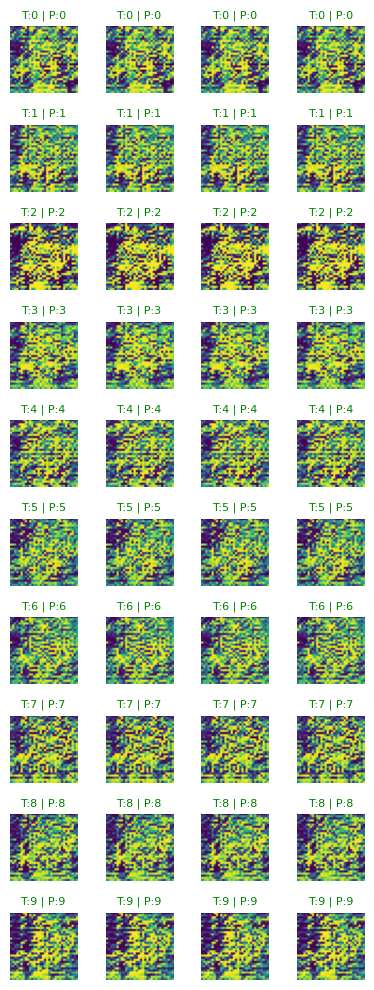

[GEN] Ep 31/100 | Loss 521.0972 | KL 1.2670 | CE 0.1630 | COS 0.2424 | ORT 0.1180 | SSIM 0.0013 | time 27.6s
[GEN] Ep 32/100 | Loss 521.5365 | KL 1.2604 | CE 0.1630 | COS 0.2432 | ORT 0.1183 | SSIM 0.0013 | time 27.5s
[GEN] Ep 33/100 | Loss 520.3815 | KL 1.2616 | CE 0.1645 | COS 0.2423 | ORT 0.1177 | SSIM 0.0013 | time 27.5s
[GEN] Ep 34/100 | Loss 519.7232 | KL 1.2586 | CE 0.1643 | COS 0.2422 | ORT 0.1174 | SSIM 0.0013 | time 27.7s
[GEN] Ep 35/100 | Loss 518.8154 | KL 1.2594 | CE 0.1648 | COS 0.2416 | ORT 0.1170 | SSIM 0.0013 | time 27.5s
[GEN] Ep 36/100 | Loss 516.8161 | KL 1.2561 | CE 0.1633 | COS 0.2408 | ORT 0.1164 | SSIM 0.0013 | time 27.5s
[GEN] Ep 37/100 | Loss 516.0984 | KL 1.2535 | CE 0.1650 | COS 0.2403 | ORT 0.1162 | SSIM 0.0013 | time 27.6s
[GEN] Ep 38/100 | Loss 516.1379 | KL 1.2498 | CE 0.1653 | COS 0.2403 | ORT 0.1165 | SSIM 0.0013 | time 27.5s
[GEN] Ep 39/100 | Loss 513.7629 | KL 1.2503 | CE 0.1663 | COS 0.2390 | ORT 0.1152 | SSIM 0.0013 | time 27.5s
[GEN] Ep 40/100 | L

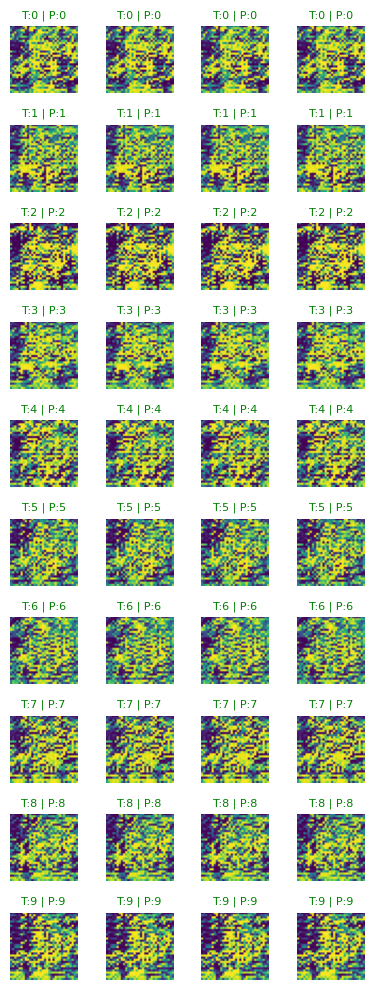

[GEN] Ep 41/100 | Loss 513.9959 | KL 1.2428 | CE 0.1662 | COS 0.2393 | ORT 0.1159 | SSIM 0.0013 | time 27.8s
[GEN] Ep 42/100 | Loss 514.2399 | KL 1.2467 | CE 0.1667 | COS 0.2392 | ORT 0.1157 | SSIM 0.0013 | time 27.7s
[GEN] Ep 43/100 | Loss 514.1634 | KL 1.2444 | CE 0.1686 | COS 0.2392 | ORT 0.1155 | SSIM 0.0013 | time 27.6s
[GEN] Ep 44/100 | Loss 512.3715 | KL 1.2469 | CE 0.1668 | COS 0.2383 | ORT 0.1147 | SSIM 0.0013 | time 27.5s
[GEN] Ep 45/100 | Loss 511.4320 | KL 1.2388 | CE 0.1678 | COS 0.2378 | ORT 0.1149 | SSIM 0.0013 | time 27.6s
[GEN] Ep 46/100 | Loss 511.8670 | KL 1.2385 | CE 0.1693 | COS 0.2380 | ORT 0.1149 | SSIM 0.0013 | time 27.6s
[GEN] Ep 47/100 | Loss 511.3865 | KL 1.2387 | CE 0.1683 | COS 0.2377 | ORT 0.1149 | SSIM 0.0013 | time 27.7s
[GEN] Ep 48/100 | Loss 509.0459 | KL 1.2397 | CE 0.1682 | COS 0.2364 | ORT 0.1138 | SSIM 0.0013 | time 27.5s
[GEN] Ep 49/100 | Loss 511.1707 | KL 1.2346 | CE 0.1700 | COS 0.2374 | ORT 0.1151 | SSIM 0.0013 | time 27.6s
[GEN] Ep 50/100 | L

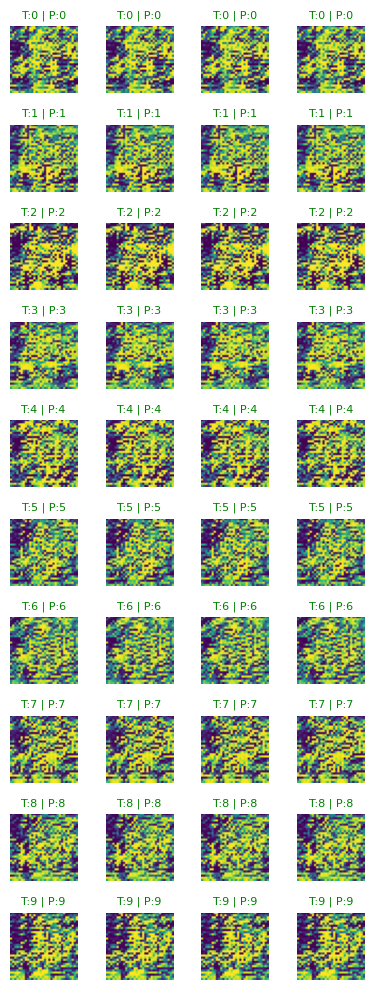

[GEN] Ep 51/100 | Loss 510.1342 | KL 1.2350 | CE 0.1704 | COS 0.2369 | ORT 0.1144 | SSIM 0.0013 | time 27.6s
[GEN] Ep 52/100 | Loss 508.8362 | KL 1.2354 | CE 0.1692 | COS 0.2362 | ORT 0.1141 | SSIM 0.0012 | time 27.5s
[GEN] Ep 53/100 | Loss 509.2053 | KL 1.2320 | CE 0.1708 | COS 0.2364 | ORT 0.1142 | SSIM 0.0012 | time 27.5s
[GEN] Ep 54/100 | Loss 509.6193 | KL 1.2340 | CE 0.1714 | COS 0.2366 | ORT 0.1141 | SSIM 0.0012 | time 27.7s
[GEN] Ep 55/100 | Loss 507.9574 | KL 1.2277 | CE 0.1703 | COS 0.2362 | ORT 0.1137 | SSIM 0.0012 | time 27.5s
[GEN] Ep 56/100 | Loss 509.4291 | KL 1.2291 | CE 0.1723 | COS 0.2365 | ORT 0.1143 | SSIM 0.0012 | time 27.6s
[GEN] Ep 57/100 | Loss 507.2992 | KL 1.2287 | CE 0.1713 | COS 0.2355 | ORT 0.1134 | SSIM 0.0012 | time 27.6s
[GEN] Ep 58/100 | Loss 507.5950 | KL 1.2257 | CE 0.1716 | COS 0.2356 | ORT 0.1139 | SSIM 0.0012 | time 27.5s
[GEN] Ep 59/100 | Loss 506.4150 | KL 1.2285 | CE 0.1701 | COS 0.2349 | ORT 0.1134 | SSIM 0.0012 | time 27.5s
[GEN] Ep 60/100 | L

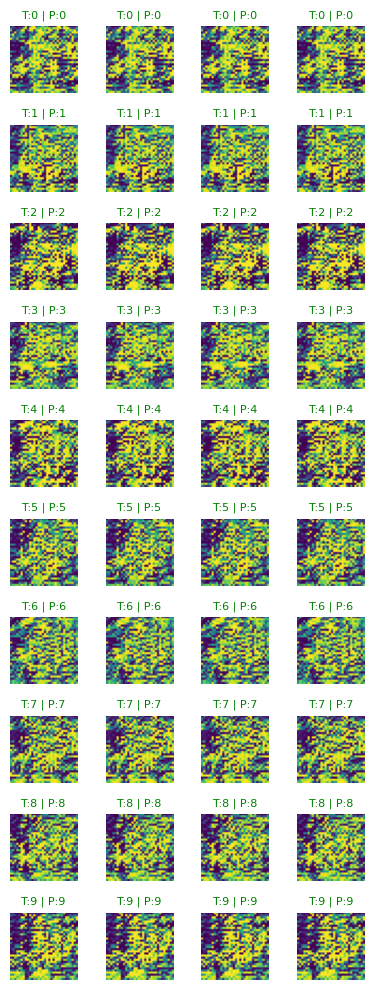

[GEN] Ep 61/100 | Loss 505.9761 | KL 1.2255 | CE 0.1724 | COS 0.2347 | ORT 0.1130 | SSIM 0.0012 | time 27.5s
[GEN] Ep 62/100 | Loss 505.3533 | KL 1.2267 | CE 0.1722 | COS 0.2343 | ORT 0.1127 | SSIM 0.0012 | time 27.6s
[GEN] Ep 63/100 | Loss 505.4455 | KL 1.2245 | CE 0.1723 | COS 0.2343 | ORT 0.1131 | SSIM 0.0012 | time 27.6s
[GEN] Ep 64/100 | Loss 505.2193 | KL 1.2232 | CE 0.1730 | COS 0.2342 | ORT 0.1129 | SSIM 0.0012 | time 27.5s
[GEN] Ep 65/100 | Loss 506.1313 | KL 1.2243 | CE 0.1734 | COS 0.2345 | ORT 0.1133 | SSIM 0.0012 | time 27.5s
[GEN] Ep 66/100 | Loss 504.6790 | KL 1.2200 | CE 0.1741 | COS 0.2339 | ORT 0.1127 | SSIM 0.0012 | time 27.6s
[GEN] Ep 67/100 | Loss 504.3335 | KL 1.2206 | CE 0.1729 | COS 0.2337 | ORT 0.1128 | SSIM 0.0012 | time 27.6s
[GEN] Ep 68/100 | Loss 504.4113 | KL 1.2183 | CE 0.1744 | COS 0.2338 | ORT 0.1127 | SSIM 0.0012 | time 27.5s
[GEN] Ep 69/100 | Loss 503.9905 | KL 1.2181 | CE 0.1748 | COS 0.2336 | ORT 0.1124 | SSIM 0.0012 | time 27.5s
[GEN] Ep 70/100 | L

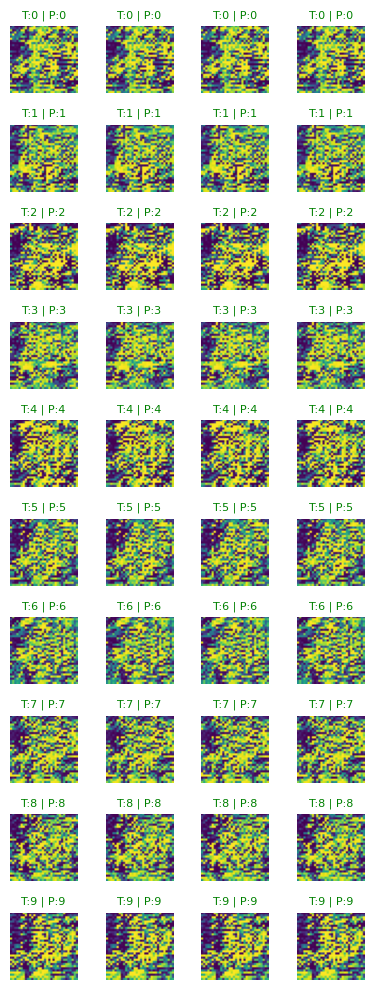

[GEN] Ep 71/100 | Loss 503.6744 | KL 1.2195 | CE 0.1739 | COS 0.2332 | ORT 0.1125 | SSIM 0.0012 | time 27.5s
[GEN] Ep 72/100 | Loss 504.6918 | KL 1.2187 | CE 0.1738 | COS 0.2339 | ORT 0.1130 | SSIM 0.0012 | time 27.5s
[GEN] Ep 73/100 | Loss 503.5453 | KL 1.2148 | CE 0.1729 | COS 0.2335 | ORT 0.1128 | SSIM 0.0012 | time 27.6s
[GEN] Ep 74/100 | Loss 502.1480 | KL 1.2154 | CE 0.1746 | COS 0.2325 | ORT 0.1120 | SSIM 0.0012 | time 27.6s
[GEN] Ep 75/100 | Loss 502.8894 | KL 1.2161 | CE 0.1750 | COS 0.2328 | ORT 0.1123 | SSIM 0.0012 | time 27.5s
[GEN] Ep 76/100 | Loss 503.2822 | KL 1.2158 | CE 0.1738 | COS 0.2330 | ORT 0.1127 | SSIM 0.0012 | time 27.5s
[GEN] Ep 77/100 | Loss 502.2972 | KL 1.2143 | CE 0.1751 | COS 0.2326 | ORT 0.1121 | SSIM 0.0012 | time 27.6s
[GEN] Ep 78/100 | Loss 501.2551 | KL 1.2114 | CE 0.1743 | COS 0.2323 | ORT 0.1117 | SSIM 0.0012 | time 27.5s
[GEN] Ep 79/100 | Loss 501.9317 | KL 1.2167 | CE 0.1737 | COS 0.2325 | ORT 0.1118 | SSIM 0.0012 | time 27.6s
[GEN] Ep 80/100 | L

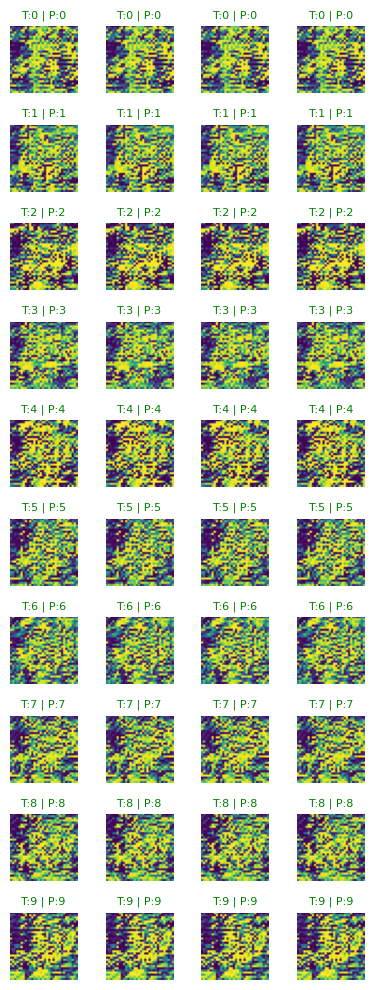

[GEN] Ep 81/100 | Loss 501.5987 | KL 1.2150 | CE 0.1754 | COS 0.2321 | ORT 0.1117 | SSIM 0.0012 | time 27.5s
[GEN] Ep 82/100 | Loss 502.1101 | KL 1.2104 | CE 0.1740 | COS 0.2328 | ORT 0.1123 | SSIM 0.0012 | time 27.6s
[GEN] Ep 83/100 | Loss 501.3898 | KL 1.2136 | CE 0.1735 | COS 0.2322 | ORT 0.1119 | SSIM 0.0012 | time 27.6s
[GEN] Ep 84/100 | Loss 501.8752 | KL 1.2115 | CE 0.1742 | COS 0.2325 | ORT 0.1122 | SSIM 0.0012 | time 27.5s
[GEN] Ep 85/100 | Loss 501.0282 | KL 1.2098 | CE 0.1749 | COS 0.2321 | ORT 0.1117 | SSIM 0.0012 | time 27.6s
[GEN] Ep 86/100 | Loss 501.5984 | KL 1.2123 | CE 0.1743 | COS 0.2323 | ORT 0.1120 | SSIM 0.0012 | time 27.7s
[GEN] Ep 87/100 | Loss 501.3743 | KL 1.2100 | CE 0.1751 | COS 0.2322 | ORT 0.1119 | SSIM 0.0012 | time 27.5s
[GEN] Ep 88/100 | Loss 500.5811 | KL 1.2060 | CE 0.1761 | COS 0.2319 | ORT 0.1117 | SSIM 0.0012 | time 27.6s
[GEN] Ep 89/100 | Loss 500.3222 | KL 1.2079 | CE 0.1761 | COS 0.2316 | ORT 0.1115 | SSIM 0.0012 | time 27.6s
[GEN] Ep 90/100 | L

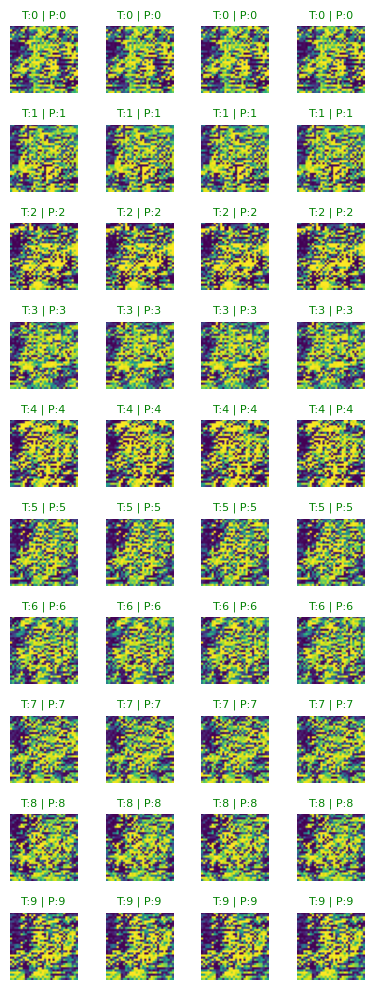

[GEN] Ep 91/100 | Loss 499.5817 | KL 1.2058 | CE 0.1768 | COS 0.2312 | ORT 0.1112 | SSIM 0.0012 | time 27.6s
[GEN] Ep 92/100 | Loss 500.7881 | KL 1.2076 | CE 0.1755 | COS 0.2317 | ORT 0.1120 | SSIM 0.0012 | time 27.6s
[GEN] Ep 93/100 | Loss 499.3193 | KL 1.2044 | CE 0.1751 | COS 0.2312 | ORT 0.1114 | SSIM 0.0012 | time 27.5s
[GEN] Ep 94/100 | Loss 498.5022 | KL 1.2072 | CE 0.1762 | COS 0.2306 | ORT 0.1108 | SSIM 0.0012 | time 27.6s
[GEN] Ep 95/100 | Loss 499.4915 | KL 1.2080 | CE 0.1753 | COS 0.2311 | ORT 0.1114 | SSIM 0.0012 | time 27.5s
[GEN] Ep 96/100 | Loss 499.8778 | KL 1.2067 | CE 0.1761 | COS 0.2314 | ORT 0.1114 | SSIM 0.0012 | time 27.5s
[GEN] Ep 97/100 | Loss 499.8688 | KL 1.2024 | CE 0.1757 | COS 0.2315 | ORT 0.1118 | SSIM 0.0012 | time 27.6s
[GEN] Ep 98/100 | Loss 498.4544 | KL 1.2023 | CE 0.1751 | COS 0.2309 | ORT 0.1111 | SSIM 0.0012 | time 27.6s
[GEN] Ep 99/100 | Loss 498.8825 | KL 1.2056 | CE 0.1761 | COS 0.2307 | ORT 0.1112 | SSIM 0.0012 | time 27.6s
[GEN] Ep 100/100 | 

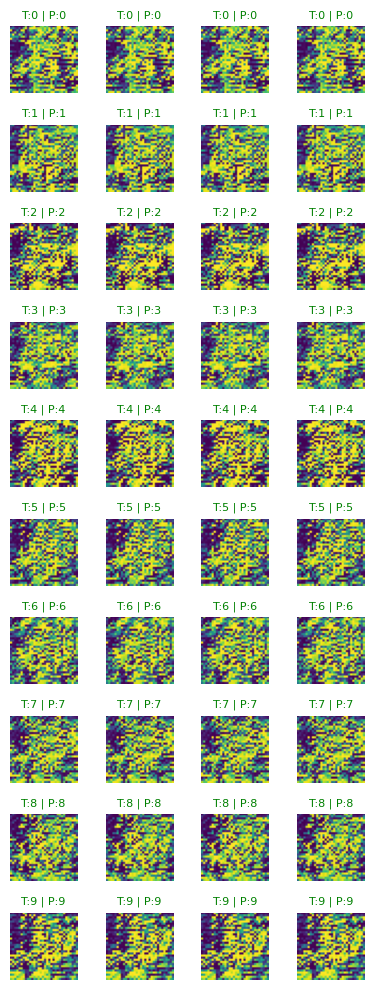

In [21]:
print("Starting generator training...")
train_generator(epochs=100, batch_size=64)



Running t-SNE evaluation...
[t-SNE] Inversion Accuracy: 73.00%


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


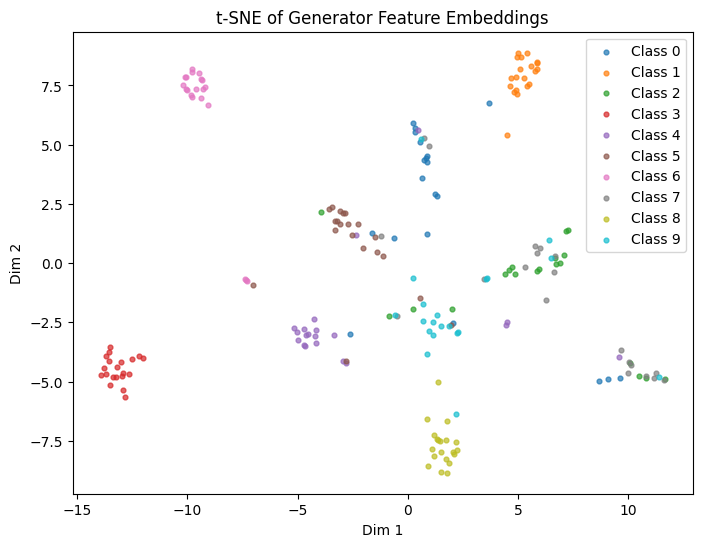

In [22]:
# Final t-SNE visualization
print("Running t-SNE evaluation...")
eval_tsne_grid(gen, classifier, samples_per_class=SAMPLES_PER_CLASS)

Generating final image grid...


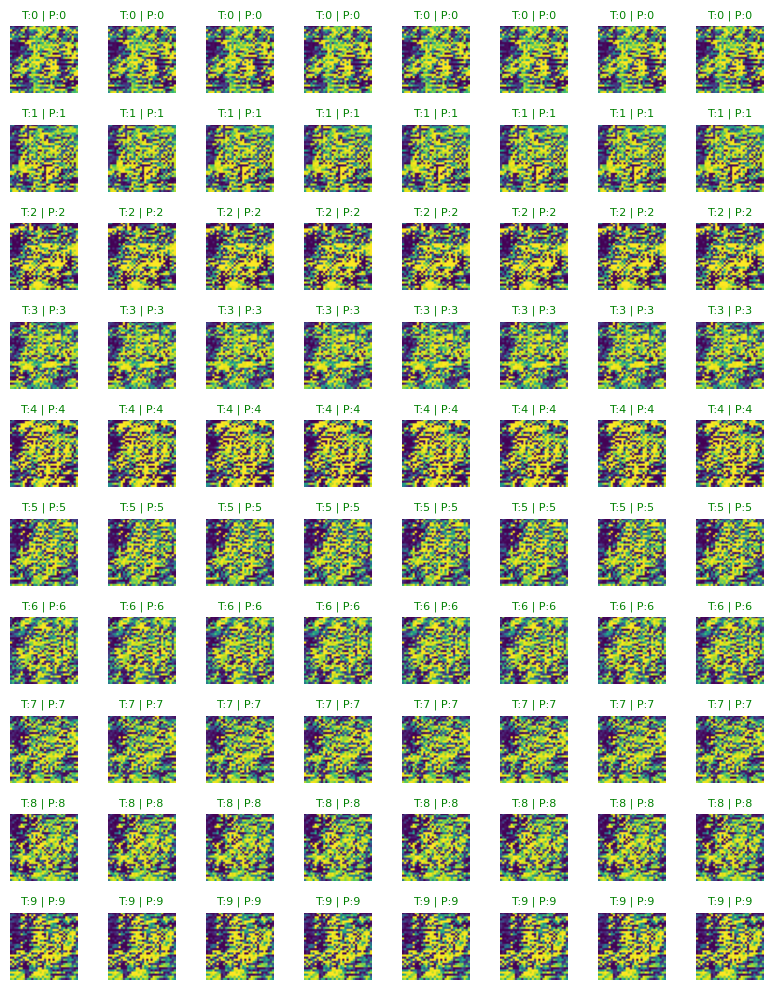

In [23]:
# Final grid of generated images
print("Generating final image grid...")
show_generated_images(gen, classifier, samples_per_class=8)

In [24]:
final_acc = inversion_accuracy(gen, classifier, n_per_class=100)
print(f"FINAL INVERSION ACCURACY: {final_acc:.2f}%")

FINAL INVERSION ACCURACY: 100.00%
